## Linear regression model for car price forecasting

Importing all necessary modules

In [1907]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import itertools as it

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import category_encoders as ce
from statsmodels.graphics.regressionplots import *

import eli5
from eli5.sklearn import PermutationImportance

import seaborn as sns
sns.set()

Importing dataset. We can observe that there are numeric and categorical columns. So we'll further need to encode categorical ones to use them in our model.

In [1908]:
data = pd.read_csv('1.04. Real-life example.csv')
data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


Summary statistics show that there are some missing values and possible outliers.

In [1909]:
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Avg_price_in_year,Model,Brand_Model,Brand_Body,Brand_Engine Type,Brand_Year,Model_Body,Model_Engine Type,Model_Year,Body_Engine Type,Body_Year,Engine Type_Year
count,3764,3764.000000,3764,3764.000000,3764.000000,3764,3764,3764.000000,3764,3764,3764,3764,3764,3764,3764,3764,3764,3764,3764
unique,7,NaN,6,NaN,NaN,4,2,NaN,283,284,41,28,213,478,530,1318,24,174,121
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class,Mercedes-Benz_E-Class,BMW_sedan,Volkswagen_Diesel,Volkswagen_2012,E-Class_sedan,Vito_Diesel,Kangoo_2012,sedan_Petrol,sedan_2007,Diesel_2012
freq,856,NaN,1455,NaN,NaN,1727,3399,NaN,185,185,343,484,98,157,149,33,734,131,199
mean,NaN,9.317350,NaN,170.637620,2.399089,NaN,NaN,2006.152763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.806603,NaN,96.848575,0.906232,NaN,NaN,6.284240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,6.684612,NaN,0.000000,0.600000,NaN,NaN,1978.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,8.839277,NaN,101.000000,1.800000,NaN,NaN,2002.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,9.305560,NaN,163.000000,2.000000,NaN,NaN,2007.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,9.878170,NaN,234.000000,3.000000,NaN,NaN,2011.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Remove missing values from target. We still have ones in the column EngineV.

In [1910]:
data.dropna(subset=['Price'],axis=0,inplace=True)

G:\Anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
G:\Anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


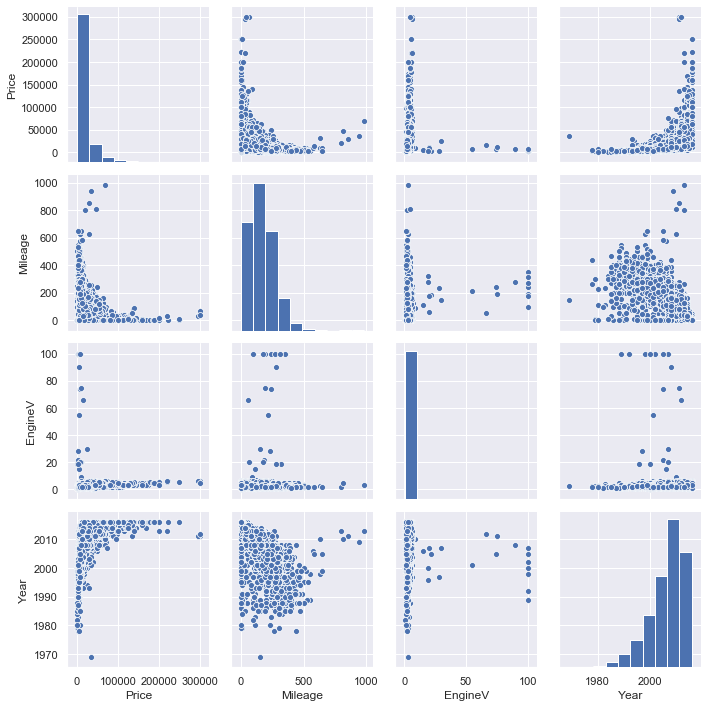

In [1912]:
sns.pairplot(data, height=2.5)
plt.tight_layout()

In [1935]:
def outliers_remove(dataset):
    
#remove outliers based on interquantile range
    for col in dataset.select_dtypes('float64','int64'):
        
        iqr=dataset[col].quantile(0.75)-dataset[col].quantile(0.25)
        dataset=dataset[dataset[col]<=dataset[col].quantile(0.75)+iqr*3]
        dataset=dataset[dataset[col]>=dataset[col].quantile(0.25)-iqr*3]
        
    return dataset


In [1936]:
def leverage_remove(dataset, X_train,y_train):

#     y_lev=dataset.Price
#     X_lev=dataset.drop('Price',axis=1)
#     X_lev=X_lev.select_dtypes(['float64','int64'])

    X_lev=X_train.select_dtypes(['float64','int64'])
    model_lev = sm.OLS(y_train, sm.add_constant(X_lev)).fit()

    influence = model_lev.get_influence()
    student_resid = influence.resid_studentized_external
    leverage = influence.hat_matrix_diag
    inf_sum = influence.summary_frame()

    sns.regplot(leverage, model_lev.resid_pearson,  fit_reg=False)
    plt.title('Leverage vs. Studentized Residuals')
    plt.xlabel('Leverage')
    plt.ylabel('Studentized Residuals')
    plt.show()

    price_res = pd.concat([y_train, inf_sum], axis = 1)
    price_res=price_res.rename(columns={'hat_diag': 'leverage'})

    r = price_res.student_resid
    print ('Outliers:', price_res.Price[abs(r) > 3].count())
    outliers= price_res.Price[abs(r) > 3]
    l = price_res.leverage
    print ('High leverage:',price_res.Price[abs(l) > ((2*X_train.shape[1])+2)/X_train.shape[0]].count())
    leverage =price_res.Price[abs(l) > ((2*X_train.shape[1])+2)/X_train.shape[0]]

    outliers_index = outliers.index
    leverage_index = leverage.index
    data_index = dataset.index


    data=dataset[data_index.isin(outliers_index)==False]
    data=dataset[data_index.isin(leverage_index)==False]


    return data

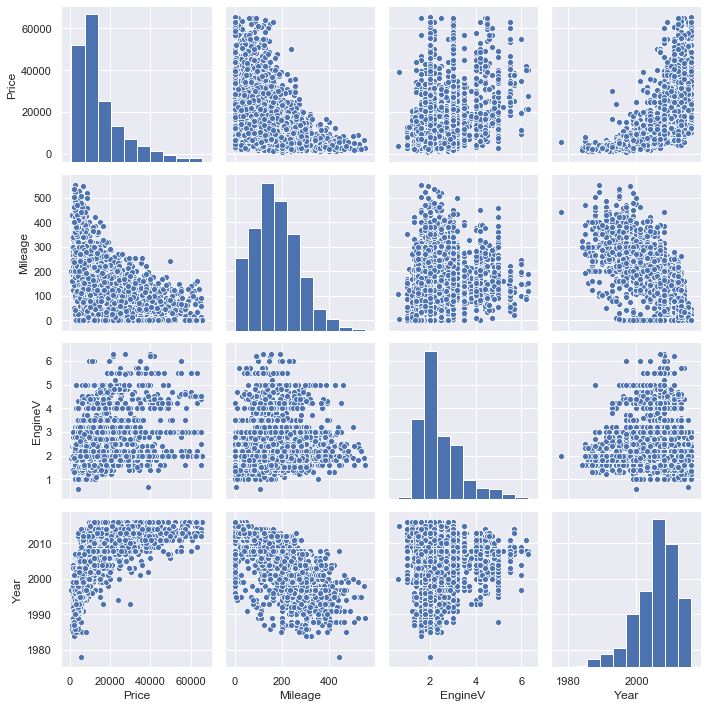

In [1915]:
sns.pairplot(data, height=2.5)
plt.tight_layout()

In [1916]:
def multicolinearity_check(X):
    variables=X.select_type('float64','int64')
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    vif["features"] = variables.columns
    return vif

In [1917]:
def create_interactions(dataset):
    cat_features = dataset.select_type('object').columns
    name=""
    for item in it.combinations(cat_features, 2):
        name=item[0]+"_"+item[1]
        dataset[name]=dataset[item[0]].astype('str')+"_"+dataset[item[1]].astype('str')
    
    return dataset

In [1918]:
def features_importance(model, X_train, y_train):

    X_tocheck=X_train.select_dtypes('float64')

    model.fit(X_tocheck, y_train)
    perm = PermutationImportance(model, random_state=0).fit(X_tocheck, y_train)
    return eli5.show_weights(perm, feature_names = X_tocheck.columns.tolist())
    

In [1923]:
def preprocessing(X_train):
    
    # Select categorical columns with relatively low and high cardinality 
    
    categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                            X_train[cname].dtype == "object"]

    big_categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() >= 10 and 
                            X_train[cname].dtype == "object"]

    # Select numerical columns
    numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    # Preprocessing for categorical data
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

    big_categorical_transformer=ce.TargetEncoder()


    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols),
            ('big_cat',big_categorical_transformer, big_categorical_cols)
        ])

In [ ]:
def OLS_with_summary(X_train, y_train):
    
    preprocessor=preprocessing(X_train)
    X_train_OLS=preprocessor.fit_transform(X_train)
    
    X = sm.add_constant(X_train_OLS)
    model_OLS = sm.OLS(y_train,X)
    results = model_OLS.fit()
    return results.summary()

In [ ]:
def pipeline_fit(model, preprocessor, X_train,y_train):
    
    # Bundle preprocessing and modeling code in a pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

    # Preprocessing of training data, fit model 
    my_pipeline.fit(X_train, y_train)
    
    return my_pipeline

In [1939]:
def predictions(pipeline, X_test, y_test):

    # Preprocessing of validation data, get predictions
    preds = pipeline.predict(X_test)
   

    
    
    #R2=r2_score(np.exp(y_test), np.exp(preds))
    #adj_R2=1-(1-R2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)

    #Create data frame with predictions and residuals
    predictions=pd.DataFrame(np.exp(preds), columns=['Prediction'])
    y_test = y_test.reset_index(drop=True)
    
    predictions['Target']=np.exp(y_test)
    predictions['Residuals']=predictions['Target']-predictions['Prediction']
    predictions['Difference%'] = np.absolute(predictions['Residuals']/predictions['Target']*100)
    
    # Evaluate the model
    score = mean_absolute_error(np.exp(y_test), np.exp(preds))
    MAPE=abs(predictions['Residuals'].sum())/predictions['Target'].sum()*100
    #print('R2:',R2.round(decimals=3))
    #print('adj_R2:',adj_R2.round(decimals=3))
    print('MAE:', score.round(decimals=3))
    print('MAPE:', MAPE.round(decimals=3))
    
    return predictions


In [ ]:
data['Year'].astype('str')
data['Price']= np.log(data['Price'])
y=data.Price
X=data.drop(['Price','Brand_Model','Model','Brand_Engine Type','Brand_Body','Body_Engine Type','Model_Body','Engine Type_Year','Model_Year','Body_Year','Model_Engine Type'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [1927]:
print(predictions.sort_values(by=['Difference%']).tail(10))
predictions.describe()

       Prediction   Target     Residuals  Difference%
225   5006.812117   2400.0  -2606.812117   108.617172
134  12211.778918   5850.0  -6361.778918   108.748358
334  17509.656584   8200.0  -9309.656584   113.532397
278   5241.972433   2400.0  -2841.972433   118.415518
647   8770.083115   4000.0  -4770.083115   119.252078
611  49059.113601  21500.0 -27559.113601   128.181924
402   3111.837759   1200.0  -1911.837759   159.319813
680   5706.801925   2200.0  -3506.801925   159.400087
636  12986.682490   3500.0  -9486.682490   271.048071
697  14487.691234   2500.0 -11987.691234   479.507649


,Prediction,Target,Residuals,Difference%
count,753.000000,753.000000,753.000000,753.000000
mean,14347.620448,14608.127463,260.507015,21.797722
std,10341.974651,12009.344213,4651.952954,28.048220
min,1477.123010,1185.600000,-27559.113601,0.037086
25%,6737.402120,6700.000000,-1630.802800,7.662069
50%,11789.917547,11111.000000,-159.484093,14.436717
75%,19062.317318,18400.000000,1466.974722,27.104928
max,63177.969626,65500.000000,31120.368901,479.507649


Text(0, 0.5, 'Residuals')

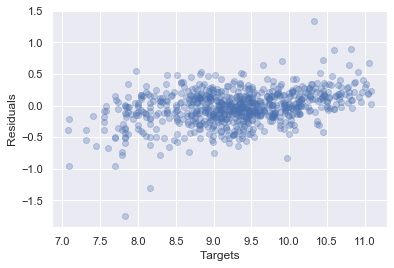

In [1928]:
plt.scatter(y_test,y_test-preds,alpha=0.3)
plt.xlabel('Targets',size=12)
plt.ylabel('Residuals',size=12)

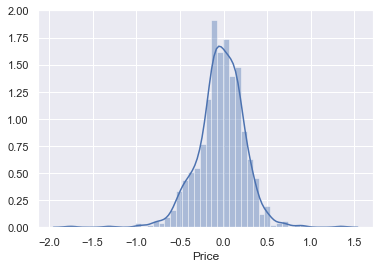

In [1929]:
sns.distplot(y_test-preds)

(6.5, 12)

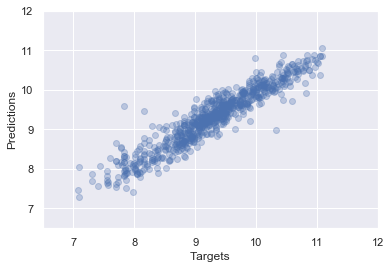

In [1930]:

plt.scatter(y_test,preds,alpha=0.3)
plt.xlabel('Targets',size=12)
plt.ylabel('Predictions',size=12)
plt.xlim(6.5,12)
plt.ylim(6.5,12)


In [1931]:
scores=cross_val_score(my_pipeline, X, y, cv=5)
print('Accuracy:',scores.mean().round(decimals=3))

Accuracy: 0.882


,VIF,features
0,2.143701,Mileage
1,1.004982,EngineV
2,2.146440,Avg_price_in_year
3,1.003707,Brand_Year
